In [ ]:
!pip install  efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.applications import MobileNetV2
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2

In [ ]:
train_data_dir = '/content/drive/MyDrive/Face Mask Dataset/Train'
test_data_dir = '/content/drive/MyDrive/Face Mask Dataset/Test'
valid_data_dir = '/content/drive/MyDrive/Face Mask Dataset/Validation'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TARGET_SIZE =   (224,224)
BATCH_SIZE = 128
INIT_LR = 1e-4
EPOCHS = 3

In [ ]:
def mould_data(path_data):
    filenames = glob(path_data+'/*/*')
    lable_name = []
    file_path = []
    for filename in filenames:
        category = filename.split('/')[-2]
        file_path.append(filename)
        lable_name.append(category)


    df = pd.DataFrame({
        'file_path': file_path,
        'label_name': lable_name
    })
    return df

In [ ]:
train_df = mould_data(train_data_dir)
# train_df , test2_df= train_test_split(train_df,test_size=0.80,stratify=train_df['label_name'])
val_df = mould_data(valid_data_dir)
test_df = mould_data(test_data_dir )
train_df.head()

file_path label_name
0  /content/drive/MyDrive/Face Mask Dataset/Train...   WithMask
1  /content/drive/MyDrive/Face Mask Dataset/Train...   WithMask
2  /content/drive/MyDrive/Face Mask Dataset/Train...   WithMask
3  /content/drive/MyDrive/Face Mask Dataset/Train...   WithMask
4  /content/drive/MyDrive/Face Mask Dataset/Train...   WithMask

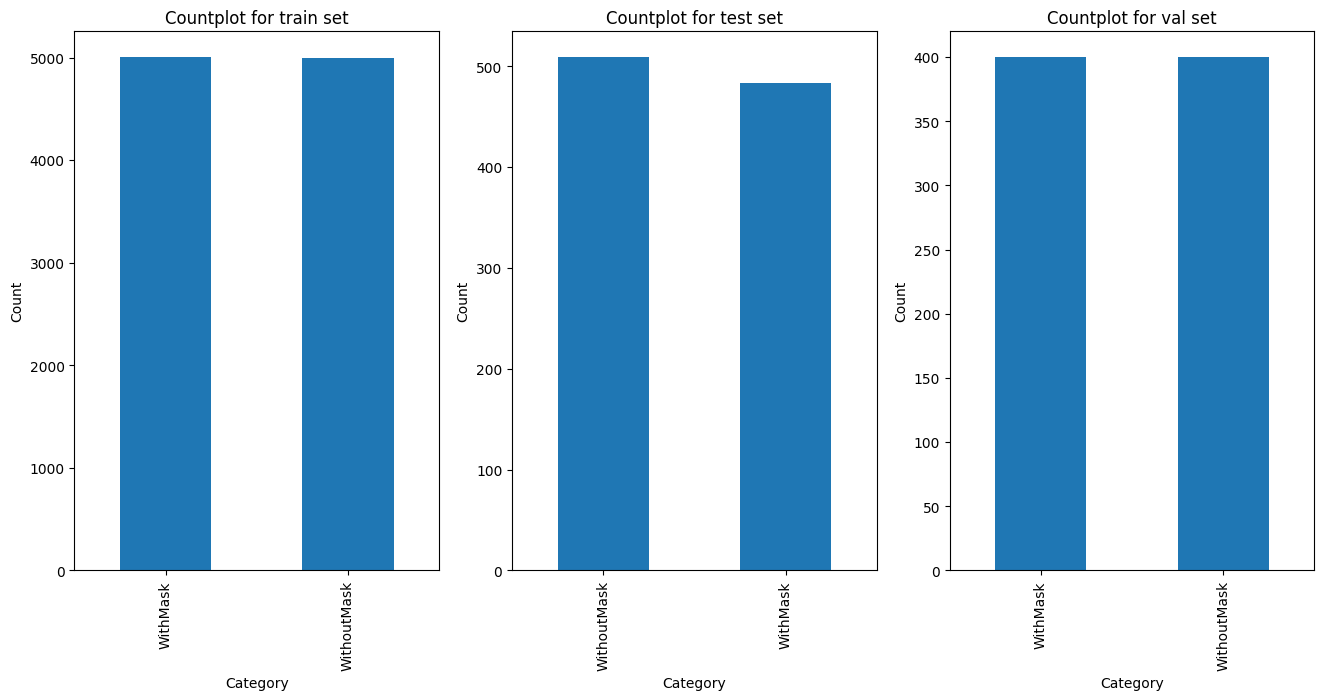

In [ ]:
fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=3)
train_df['label_name'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
test_df ['label_name'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for test set')
val_df['label_name'].value_counts().plot(ax=ax[2],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
plt.show()

**# Data augmentation for training dataset**

In [ ]:

train_gen = ImageDataGenerator(
    rotation_range=20,
    rescale=1/255.0,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function = preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = preprocess_input
)


In [ ]:
train_set = train_gen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label_name',
    target_size=TARGET_SIZE,
    class_mode='categorical',
    shuffle=True,
    batch_size=BATCH_SIZE)
val_set = val_gen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label_name',
    target_size=TARGET_SIZE,
    class_mode='categorical',
    shuffle=True,
    batch_size=BATCH_SIZE)


Found 10004 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [ ]:
train_set[0]

(array([[[[0.18424146, 0.11995663, 0.10034879],
          [0.21107118, 0.13826871, 0.1208751 ],
          [0.2392157 , 0.16078432, 0.14901961],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.18039216, 0.11764707, 0.09803922],
          [0.20129874, 0.13045076, 0.11110267],
          [0.2392157 , 0.16078432, 0.14901961],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.18039216, 0.11764707, 0.09803922],
          [0.19576317, 0.12686966, 0.10726182],
          [0.23411462, 0.15670344, 0.14391853],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.18823531, 0.16078432, 0.14901961],
          [0.18823

In [ ]:
class_dict = {v:k for k,v in train_set.class_indices.items()}
class_dict , train_set.class_indices.items()

({0: 'WithMask', 1: 'WithoutMask'},
 dict_items([('WithMask', 0), ('WithoutMask', 1)]))

In [ ]:
def visualize(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()


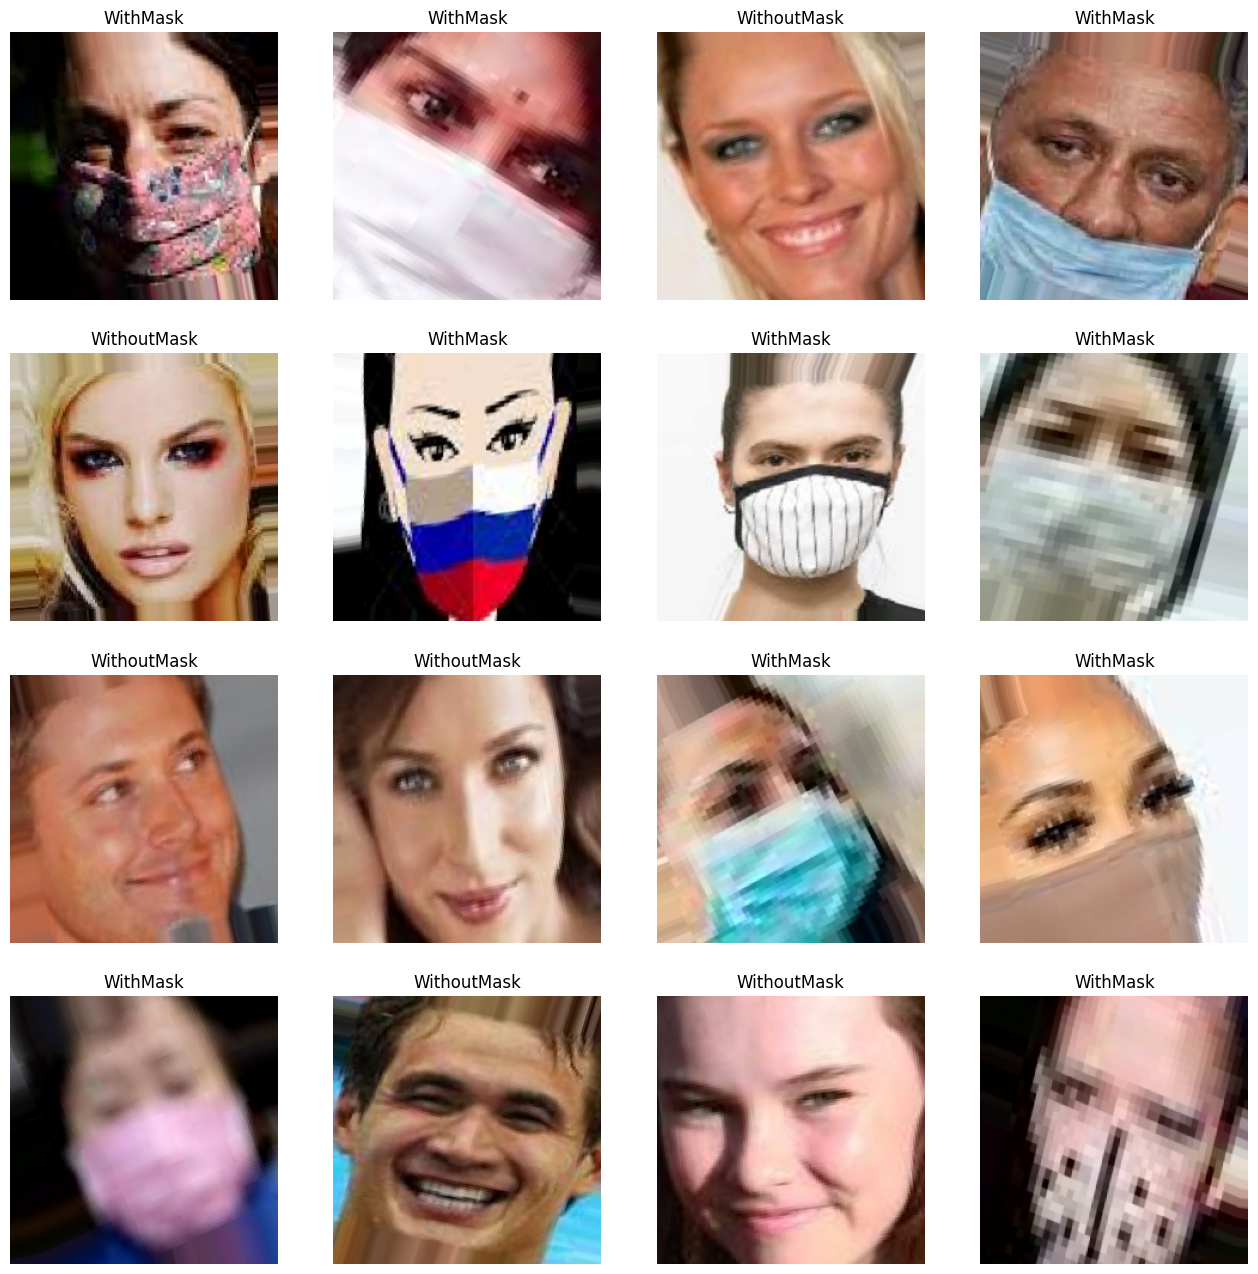

In [ ]:
visualize(train_set)


**# Visualize the validation dataset**

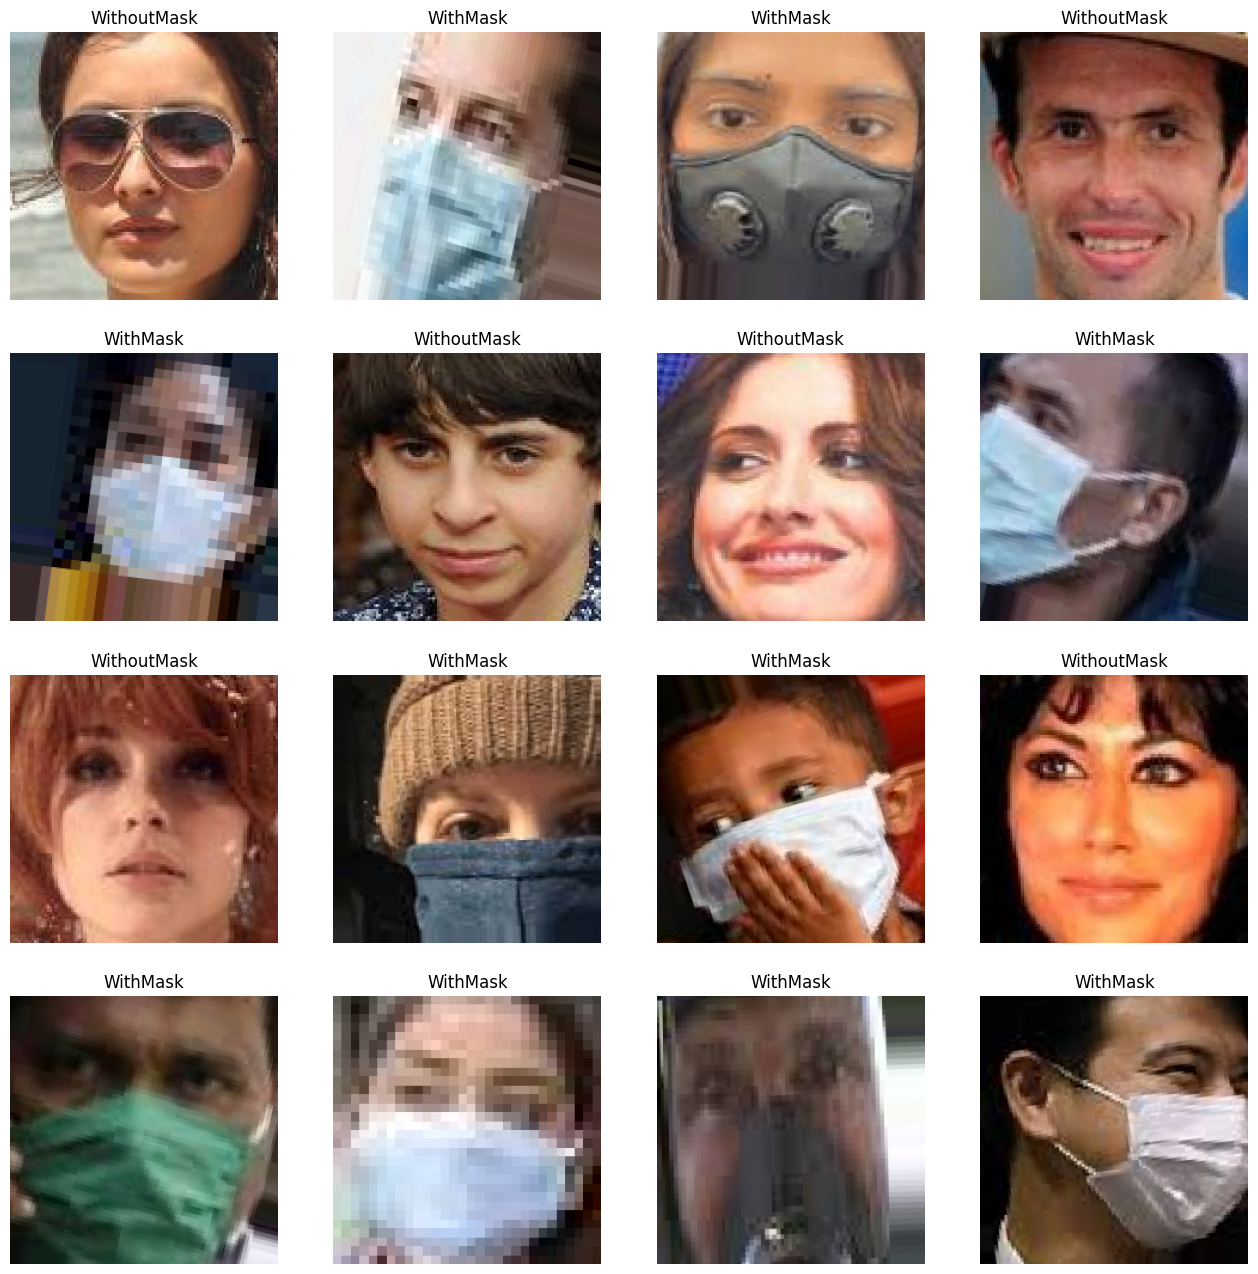

In [ ]:


visualize(val_set)

In [ ]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(TARGET_SIZE[0],TARGET_SIZE[1], 3))

16804768/16804768 [==============================] - 0s 0us/step


In [ ]:
conv_base.trainable=True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = Sequential([
    conv_base,
    Flatten(),

    Dense(units=512, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

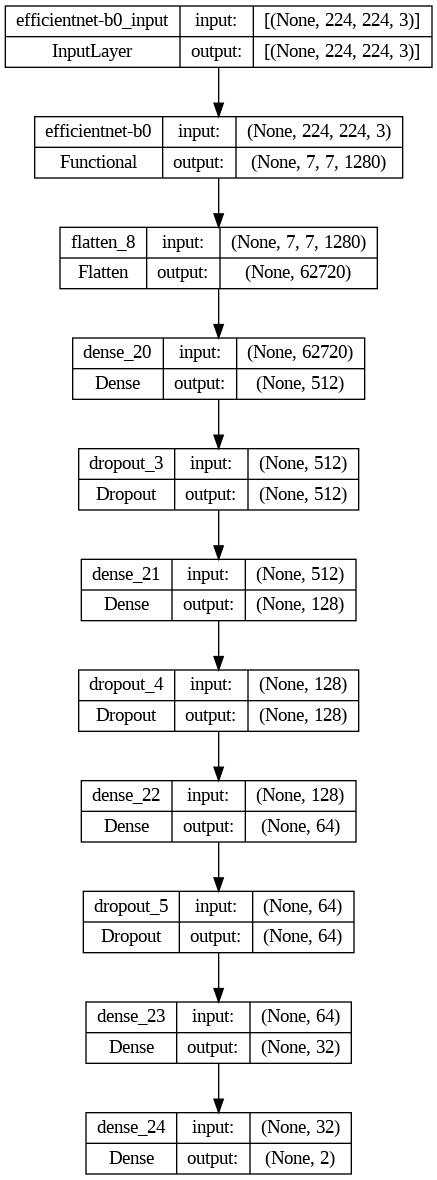

In [ ]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('Mask_detector_model.h5', save_best_only=True)
]
metrics = [
    CategoricalAccuracy(),
    Precision(),
    Recall(),
    AUC()
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [ ]:
history = model.fit(train_set,epochs=EPOCHS,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_data=val_set,
                    validation_steps=val_set.n//val_set.batch_size,
                   callbacks=callbacks)

Epoch 1/3
78/78 [==============================] - 1613s 21s/step - loss: 0.0217 - categorical_accuracy: 0.9944 - precision_4: 0.9944 - recall_4: 0.9944 - auc_4: 0.9978 - val_loss: 0.0329 - val_categorical_accuracy: 0.9948 - val_precision_4: 0.9948 - val_recall_4: 0.9948 - val_auc_4: 0.9948
Epoch 2/3
78/78 [==============================] - 1647s 21s/step - loss: 0.0184 - categorical_accuracy: 0.9961 - precision_4: 0.9961 - recall_4: 0.9961 - auc_4: 0.9980 - val_loss: 0.0286 - val_categorical_accuracy: 0.9948 - val_precision_4: 0.9948 - val_recall_4: 0.9948 - val_auc_4: 0.9974
Epoch 3/3
78/78 [==============================] - 1633s 21s/step - loss: 0.0034 - categorical_accuracy: 0.9991 - precision_4: 0.9991 - recall_4: 0.9991 - auc_4: 0.9997 - val_loss: 0.0166 - val_categorical_accuracy: 0.9987 - val_precision_4: 0.9987 - val_recall_4: 0.9987 - val_auc_4: 0.9987


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

loss  categorical_accuracy  precision_4  recall_4     auc_4  val_loss  \
0  0.021737              0.994431     0.994431  0.994431  0.997824  0.032858   
1  0.018369              0.996051     0.996051  0.996051  0.998049  0.028635   
2  0.003431              0.999089     0.999089  0.999089  0.999695  0.016622   

   val_categorical_accuracy  val_precision_4  val_recall_4  val_auc_4  
0                  0.994792         0.994792      0.994792   0.994785  
1                  0.994792         0.994792      0.994792   0.997382  
2                  0.998698         0.998698      0.998698   0.998696

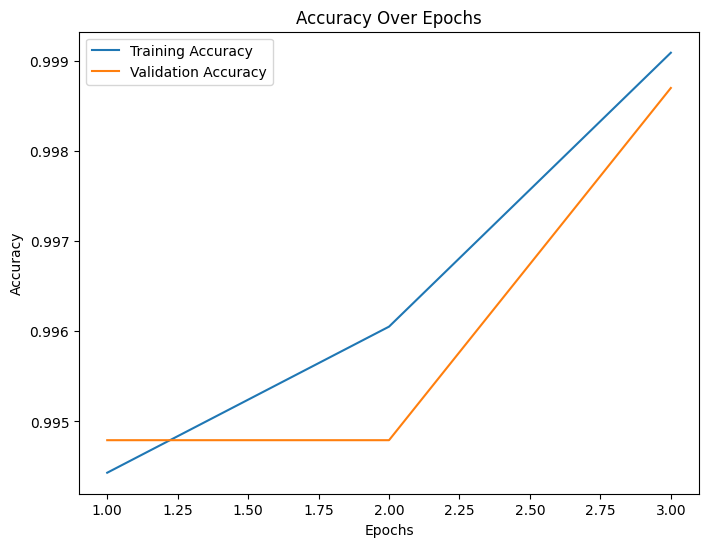

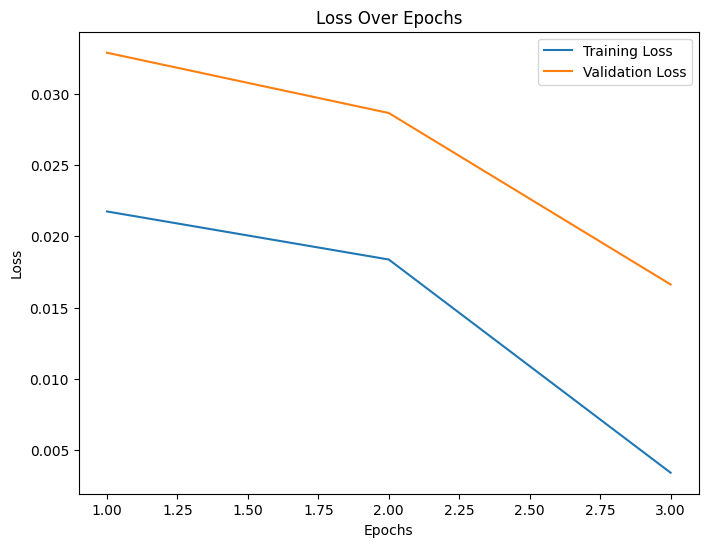

In [ ]:
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate the epoch range for x-axis
epochs_range = range(1, len(train_accuracy) + 1)

# Plot the accuracy graph
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot the loss graph
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
test_set = val_gen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label_name',
    class_mode='categorical',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 992 validated image filenames belonging to 2 classes.


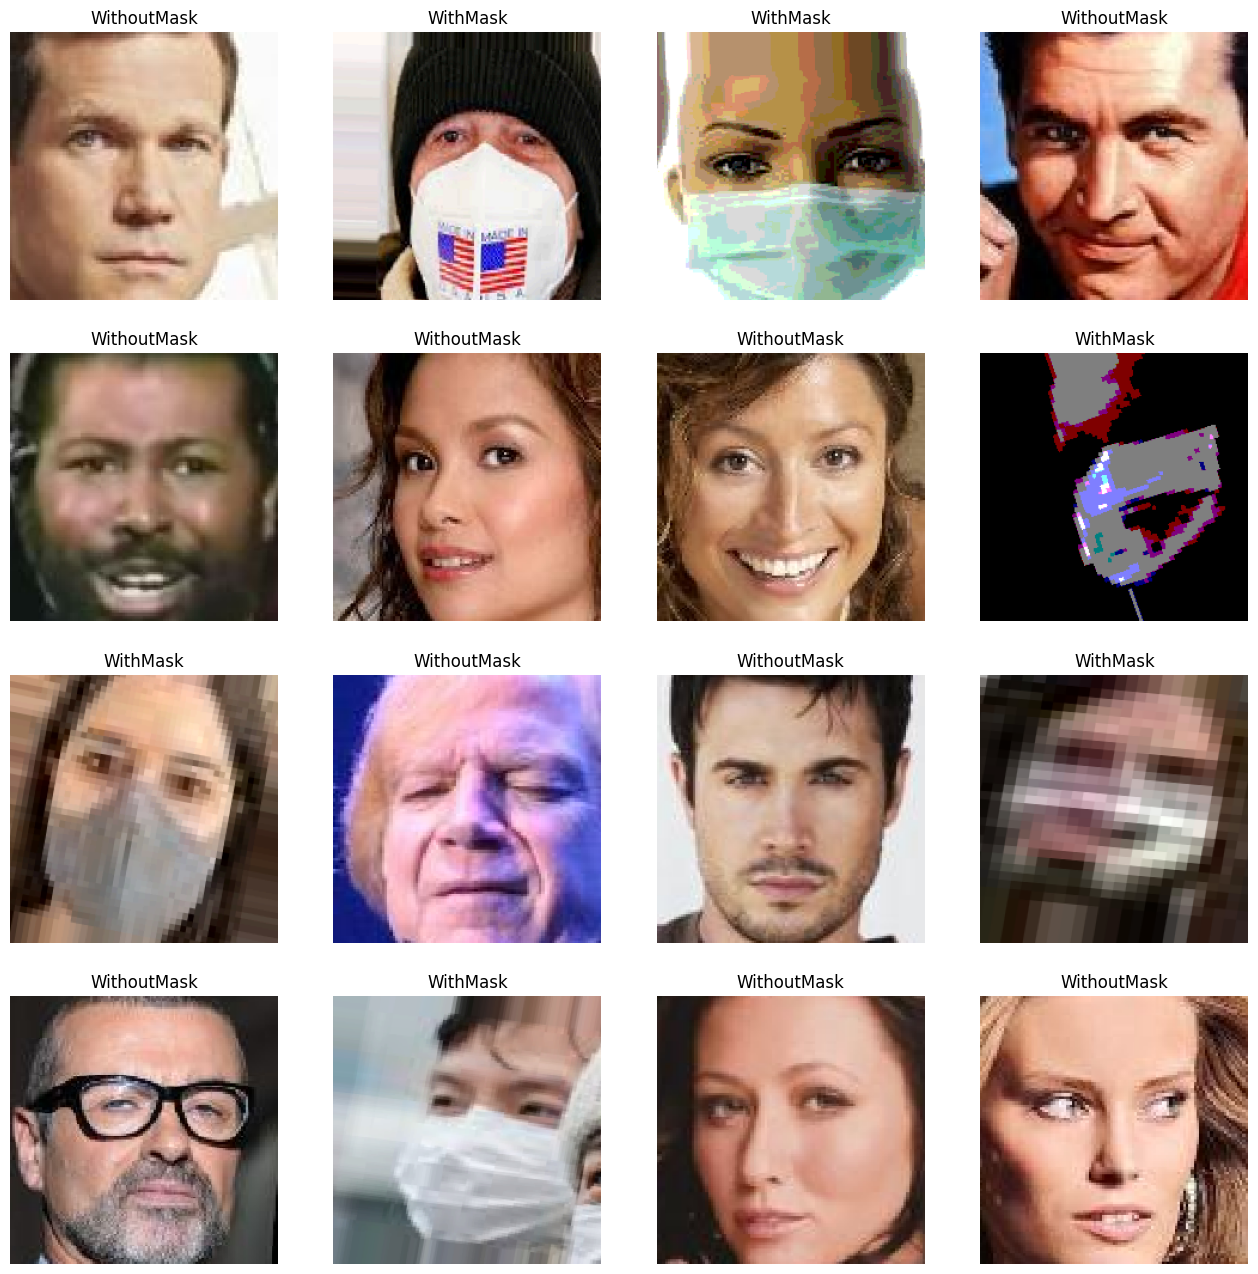

In [ ]:

visualize(test_set)

In [ ]:
best_model = load_model('Mask_detector_model.h5')

In [ ]:
test_loss,test_acc, test_precision, test_recall, test_auc = best_model.evaluate(test_set)
test_preds = best_model.predict(test_set)
test_preds =test_preds.argmax(axis=1)
test_df.head()

8/8 [==============================] - 92s 11s/step


file_path label_name
0  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask
1  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask
2  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask
3  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask
4  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask

In [ ]:
test_df['Label'] = test_df['label_name'].map(test_set.class_indices)
test_df['Predicted'] = test_preds
test_df.head()

file_path label_name  Label  \
0  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask      0   
1  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask      0   
2  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask      0   
3  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask      0   
4  /content/drive/MyDrive/Face Mask Dataset/Test/...   WithMask      0   

   Predicted  
0          0  
1          0  
2          0  
3          0  
4          0

In [ ]:
conf_mat = confusion_matrix(y_true=test_df['Label'], y_pred=test_df['Predicted'])
conf_mat = pd.DataFrame(conf_mat, index=test_set.class_indices.keys(), columns=test_set.class_indices.keys())
conf_mat

WithMask  WithoutMask
WithMask          474            9
WithoutMask         3          506

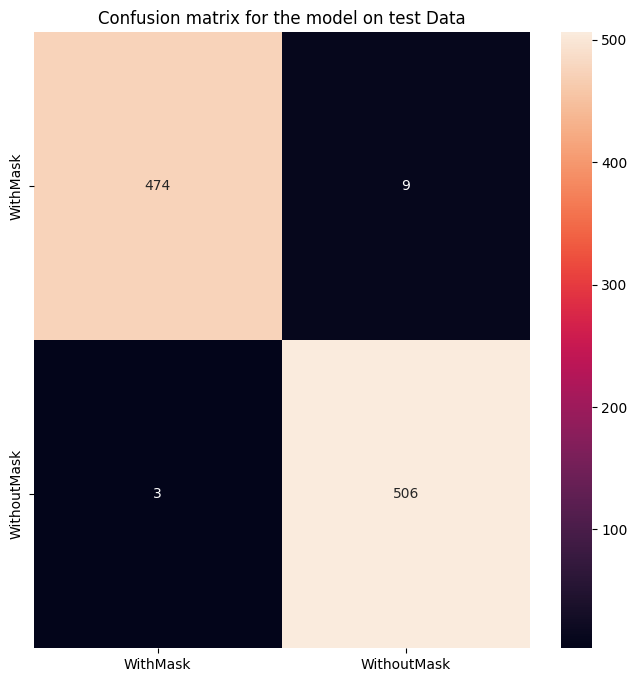

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on test Data')
plt.show()